In [1]:
import warnings
import numpy as np
import pandas as pd
import pmdarima as pm
import plotly.express as px
import statsmodels.api as sm
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error
# Load the dataset
df = pd.read_csv("rainfall.csv")

# Convert datetime string to Python datetime object and set as the index
df["datetime"] = pd.to_datetime(df["datetime"], format="%d-%m-%Y")
df.set_index("datetime", inplace=True)

#standardise
#scaler = StandardScaler()
#df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Select a specific date range
start_date = "2016-01-01"
end_date = "2025-12-31"
df = df[(df.index >= start_date) & (df.index <= end_date)]

# Display dataset information and check for missing values
df.info()
print("Missing values:")
print(df.isnull().any())
#df.plot(subplots=True,figsize=(15, 15))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1781 entries, 2016-01-01 to 2020-11-15
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              1781 non-null   float64
 1   dew               1781 non-null   float64
 2   humidity          1781 non-null   float64
 3   sealevelpressure  1781 non-null   float64
 4   winddir           1781 non-null   float64
 5   solarradiation    1781 non-null   float64
 6   windspeed         1781 non-null   float64
 7   precipprob        1781 non-null   int64  
 8   preciptype        1781 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 139.1 KB
Missing values:
temp                False
dew                 False
humidity            False
sealevelpressure    False
winddir             False
solarradiation      False
windspeed           False
precipprob          False
preciptype          False
dtype: bool


In [2]:
# Create subplots for whole data visualisation
plot_rows = 9
plot_cols = 1
fig = make_subplots(rows=plot_rows, cols=plot_cols)

# Add traces to the subplots
x = 0
for i in range(1, plot_rows + 1):
    for j in range(1, plot_cols + 1):
        fig.add_trace(
            go.Scatter(
                x=df.index, y=df[df.columns[x]].values, name=df.columns[x], mode="lines"
            ),
            row=i,
            col=j,
        )
        x += 1

# Format and display the figure
fig.update_layout(height=1200, width=1200,title_text="Daily Data")
fig.show()

In [3]:
# Resample to  week data
df = df.resample("W").mean()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255 entries, 2016-01-03 to 2020-11-15
Freq: W-SUN
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              255 non-null    float64
 1   dew               255 non-null    float64
 2   humidity          255 non-null    float64
 3   sealevelpressure  255 non-null    float64
 4   winddir           255 non-null    float64
 5   solarradiation    255 non-null    float64
 6   windspeed         255 non-null    float64
 7   precipprob        255 non-null    float64
 8   preciptype        255 non-null    float64
dtypes: float64(9)
memory usage: 19.9 KB


In [4]:
# Create subplots for bi-weekly data visualisation
plot_rows = 9
plot_cols = 1
fig = make_subplots(rows=plot_rows, cols=plot_cols)

# Add traces to the subplots
x = 0
for i in range(1, plot_rows + 1):
    for j in range(1, plot_cols + 1):
        fig.add_trace(
            go.Scatter(
                x=df.index, y=df[df.columns[x]].values, name=df.columns[x], mode="lines"
            ),
            row=i,
            col=j,
        )
        x += 1

# Format and display the figure
fig.update_layout(height=1200, width=1200,title_text="Weekly Data")
fig.show()

In [5]:
# Perform a 70-30 train-test split
""" train_start_date = "2016-01-01"
train_end_date = "2019-12-31"
test_start_date = "2019-12-31"
train = df[(df.index >= train_start_date) & (df.index <= train_end_date)]
test = df[df.index > test_start_date] """
train_percentage = 0.7
train, test = train_test_split(
    df, train_size=train_percentage, test_size=1 - train_percentage, shuffle=False
)
# Define the target column and seasonal interval (m)
train_column = "temp"
seasonal_interval = 52  # 26 is bi-weekly seasonlity # 52  Weekly seasonality

In [6]:
# Build an auto ARIMA model
model = pm.auto_arima(
    train[train_column],
    m=seasonal_interval,
    seasonal=True,
    # start_p=0,
    # start_q=0,
    test="adf",
    stepwise=True,
    trace=True,
    # suppress_warnings=True,
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=523.917, Time=4.60 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=726.000, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=524.102, Time=1.24 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=586.983, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1697.880, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=516.265, Time=4.37 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=521.435, Time=0.28 sec
 ARIMA(2,0,2)(0,0,2)[52] intercept   : AIC=515.767, Time=53.14 sec
 ARIMA(2,0,2)(1,0,2)[52] intercept   : AIC=inf, Time=55.17 sec
 ARIMA(1,0,2)(0,0,2)[52] intercept   : AIC=523.789, Time=32.40 sec
 ARIMA(2,0,1)(0,0,2)[52] intercept   : AIC=523.807, Time=40.76 sec
 ARIMA(3,0,2)(0,0,2)[52] intercept   : AIC=520.116, Time=54.31 sec
 ARIMA(2,0,3)(0,0,2)[52] intercept   : AIC=519.981, Time=49.36 sec
 ARIMA(1,0,1)(0,0,2)[52] intercept   : AIC=521.816, Time=20.61 sec
 ARIMA(1,0,3)(0,0,2)[52] inte

In [8]:
# Display model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  178
Model:             SARIMAX(2, 0, 2)x(0, 0, 2, 52)   Log Likelihood                -249.883
Date:                            Tue, 17 Oct 2023   AIC                            515.767
Time:                                    13:54:35   BIC                            541.221
Sample:                                01-03-2016   HQIC                           526.089
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4355      0.457      3.140      0.002       0.540       2.331
ar.L1          1.8599      0.055     33.780      0.000       1.752       1.968
ar.L2         -0.9106      0.048    -19.094      0.000      -1.004      -0.817
ma.L1         -1.3699      0.085    -16.130      0.000      -1.536      -1.203
ma.L2          0.4880      0.088      5.543      0.000       0.315       0.660
ma.S.L52       0.2366      0.075      3.157      0.002       0.090       0.383
ma.S.L104      0.2420      0.140      1.726      0.084      -0.033       0.517
sigma2         0.9290      0.105      8.864      0.000       0.724       1.134
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                 2.75
Prob(Q):                              0.46   Prob(JB):                         0.25
Heteroskedasticity (H):               0.58   Skew:                            -0.27
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

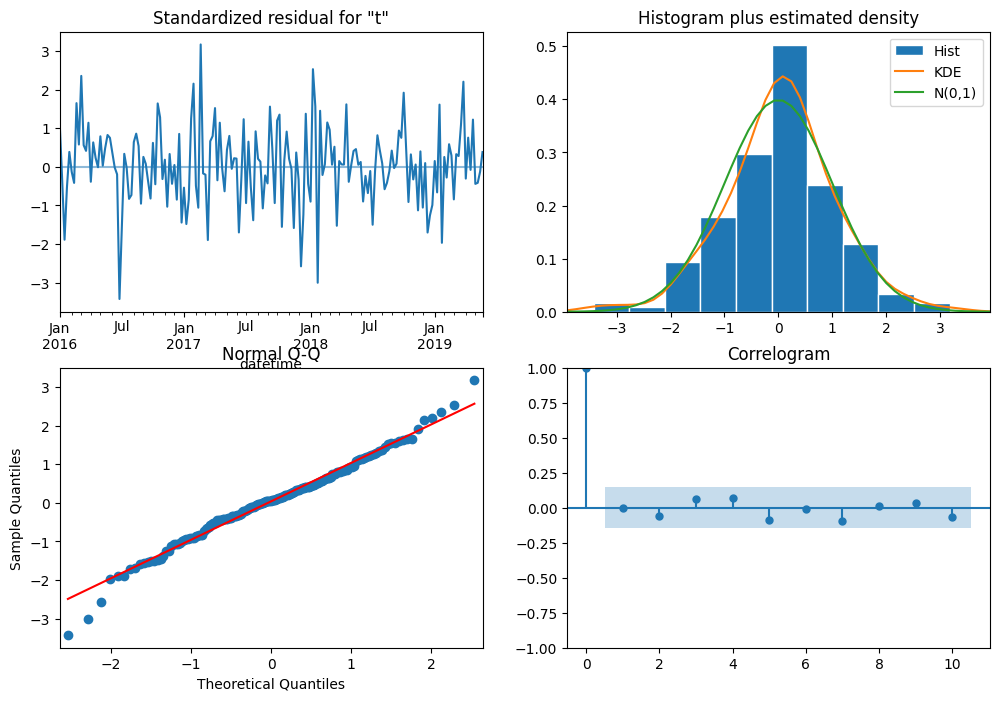

In [9]:
# Auto arima result Best model:  ARIMA(2,0,2)(0,0,2)[52]

warnings.filterwarnings("ignore")
# Fit the SARIMA model (use SARIMAX from statsmodels)
sarima_model = SARIMAX(
    train[train_column], order=(2, 0, 2), seasonal_order=(2, 0, 2, 52)
)
sarima_result = sarima_model.fit()

# Forecast vs. Actual Plot using Plotly
forecast = sarima_result.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
confidence_interval = forecast.conf_int()

# Create a Plotly figure for the forecast vs. actual plot
fig_forecast = make_subplots(rows=1, cols=1)

# Combine the historical and test data into a single series
combined_data = pd.concat([train[train_column], test[train_column]])

# Add the combined data
fig_forecast.add_trace(
    go.Scatter(
        x=combined_data.index,
        y=combined_data,
        mode="lines",
        name="Combined Data",
        line=dict(color="blue"),
    )
)

# Add forecasted data
fig_forecast.add_trace(
    go.Scatter(
        x=test.index,
        y=forecast_mean,
        mode="lines",
        name="Forecast",
        line=dict(color="red"),
    )
)

# Add confidence interval
fig_forecast.add_trace(
    go.Scatter(
        x=test.index,
        y=confidence_interval.iloc[:, 0],
        fill="tonexty",
        mode="lines",
        name="Lower CI",
        line=dict(color="pink"),
    )
)
fig_forecast.add_trace(
    go.Scatter(
        x=test.index,
        y=confidence_interval.iloc[:, 1],
        fill="tonexty",
        mode="lines",
        name="Upper CI",
        line=dict(color="pink"),
    )
)

# Customize the layout
fig_forecast.update_layout(
    title="Combined Data (Historical + Test) and Forecast",
    xaxis_title="Date",
    yaxis_title=train_column,
)

# Show the forecast vs. actual plot
fig_forecast.show()

# Residual plots with a larger figure size
sarima_result.plot_diagnostics(figsize=(12, 8))
plt.show()

In [10]:
# Evaluate the model using various metrics
observed_values = test[train_column]
forecasted_values = forecast_mean  # Use the forecasted values from your SARIMA model

# Calculate and display metrics
mse = mean_squared_error(observed_values, forecasted_values)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(observed_values - forecasted_values))
mape = np.mean(np.abs((observed_values - forecasted_values) / observed_values)) * 100
smape = np.mean(
    200
    * np.abs(observed_values - forecasted_values)
    / (np.abs(observed_values) + np.abs(forecasted_values))
)
r_squared = r2_score(observed_values, forecasted_values)

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Symmetric Mean Absolute Percentage Error (sMAPE):", smape)
print("R-squared (R²) Score:", r_squared)


Root Mean Squared Error (RMSE): 1.036333275001969
Mean Absolute Error (MAE): 0.7456792467958131
Mean Absolute Percentage Error (MAPE): 2.7079191351194307
Symmetric Mean Absolute Percentage Error (sMAPE): 2.6639514344294306
R-squared (R²) Score: 0.5817340793771971
